# COMP S493F Lab 6

In [1]:
%env TF_CPP_MIN_LOG_LEVEL=2

env: TF_CPP_MIN_LOG_LEVEL=2


In this lesson, you'll work on:

- the process of developing a suitable model for a task, and
- application of weight regularization.

### Student name: *LO TSZ KIN*

# The process of developing neural network models

Developing a suitable model for a task is an iterative process. Multiple models are created, trained, evaluated, until a suitable model is accepted. The models are mainly created or tuned based on results of preceding models.

The available data, or examples, are divided into 3 subsets:

- the training set for training each model,
- the validation set for evaluating each model, and
- the test set for evaluating the final accepted model.

There are different ways of selecting the initial model and tuning the models. One possible way is described below and adopted in this lesson.

1. Start with a simple and potentially proper model.
1. Increase model complexity until there is overfitting.
1. Regularize, or tune hyperparameters of, the model to prevent overfitting.
1. Repeat step 2 and/or step 3 until a model is accepted.

In each stage, it is ideal to examine a lot of models with different settings, but this is simply infeasible in practice due to time and resource constraints. We typically design or select a small number of models to examine based on model variety, previous experience, and validation results of preceding models.

## Utility code

Below are utility functions for use in developing the models.

This function loads the MNIST dataset, prepares the data, and returns portion of the data in a 4-tuple: `X_train`, `y_train`, `X_test`, `y_test`.

In [2]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.datasets import mnist

def load_and_prep_mnist(ratio=0.1):
    keras.utils.set_random_seed(42)
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    if ratio < 1:
        sz_train = int(len(X_train) * ratio)
        sz_test = int(len(X_test) * ratio)
        X_train, y_train = X_train[:sz_train], y_train[:sz_train]
        X_test, y_test = X_test[:sz_test], y_test[:sz_test]
    X_train_out = X_train.astype(float) / 255  # scale to range 0 to 1
    X_test_out = X_test.astype(float) / 255
    X_train_out = X_train_out.reshape(-1, 28*28)  # convert 2D to 1D
    X_test_out = X_test_out.reshape(-1, 28*28)
    y_train_oh = keras.utils.to_categorical(y_train, 10)  # one-hot encode
    y_test_oh = keras.utils.to_categorical(y_test, 10)
    return X_train_out, y_train_oh, X_test_out, y_test_oh

This function retrieves the final results in a training history, i.e. values of "loss", "val_loss", "acc", and "val_acc" in the final epoch.

In [3]:
def history_final_values(history):
    return {k: round(v[-1], 4) for k, v in history.history.items()}

This function plots a training history, including both training and validation results.

In [4]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(history.history["acc"], label="acc")
    plt.plot(history.history["val_acc"], label="val_acc")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

This function compiles and fits a model, and returns the training history. Note that the number of epochs, batch size, ratio of validation split are fixed in this function, and thus in this lesson; in reality; these are hyperparameters to be tuned in the process of model development.

In [5]:
def compile_and_fit_model(model, X_train, y_train):
    model.compile(loss="categorical_crossentropy",
                  optimizer="adam", metrics=["acc"])
    history = model.fit(X_train, y_train, epochs=50, batch_size=256,
                        verbose=0, validation_split=0.2)
    return history

# Starting with a simple model

Let's get started with a simple model. Model#1 has 1 hidden layer of 32 ReLU neurons. The model's validation results are summarized below, followed by the code and execution output.

Model | Hidden layers | Neurons in a hidden layer | Val Loss | Val Accuracy | Overfitting
:-:|:-:|:-:|:-:|:-:|:-:
#1 | 1 | 32 | 0.2550 | 0.9283 | No

11490434/11490434 [==============================] - 0s 0us/step
{'loss': 0.0731, 'acc': 0.9862, 'val_loss': 0.255, 'val_acc': 0.9283}


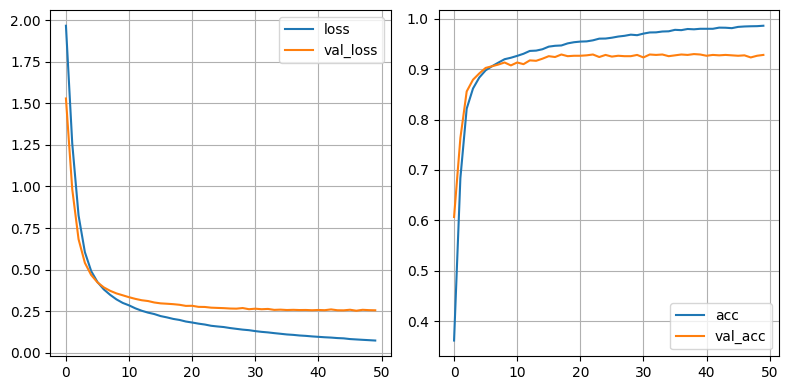

In [6]:
# Model#1
X_train, y_train, X_test, y_test = load_and_prep_mnist()
model = keras.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(10, activation="softmax")
])
history = compile_and_fit_model(model, X_train, y_train)
print(history_final_values(history))
plot_history(history)

# Increasing model complexity

Next, we try models of higher complexity. In general, more complex neural networks are more capable and have more potential to learn more from data. However, more complex models are more likely to encounter overfitting, which we should check by looking at the training history.

A few models with more hidden layers and/or neurons in a hidden layer are examined next. Their settings, validation results, code, and execution outputs are shown below.

Model | Hidden layers | Neurons in a hidden layer | Val Loss | Val Accuracy | Overfitting
:-:|:-:|:-:|:-:|:-:|:-:
#1.5A | 1 | 128 | 0.2225 | 0.9358 | No
#1.5B | 1 | 512 | 0.2033 | 0.9475 | No
#1.5C | 2 | 32 | 0.2681 | 0.9325 | Slight
#1.5D | 2 | 128 | 0.2528 | 0.9358 | Moderate
#1.5E / #2 | 2 | 512 | 0.2423 | 0.9508 | Moderate

The results show that, in general, validation loss decreases and validation accuracy increases with model complexity. Overfitting occurs with high model complexity too. Model#1.5E has the highest accuracy and is selected as the basis for improvement; it is also called Model#2 from now on.

{'loss': 0.0132, 'acc': 1.0, 'val_loss': 0.2224, 'val_acc': 0.9367}


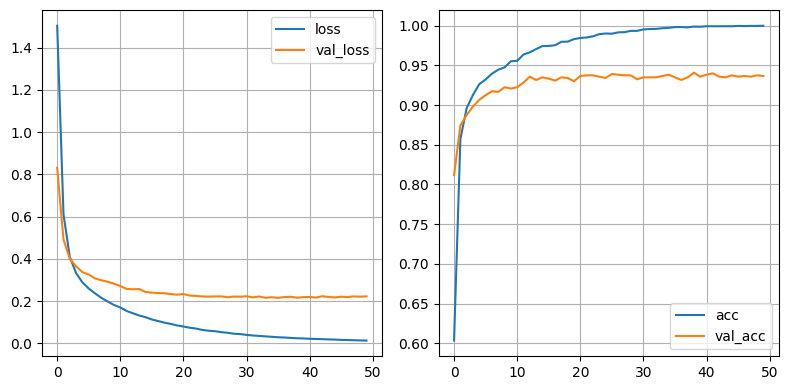

In [7]:
# Model#1.5A
X_train, y_train, X_test, y_test = load_and_prep_mnist()
model = keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax")
])
history = compile_and_fit_model(model, X_train, y_train)
print(history_final_values(history))
plot_history(history)

{'loss': 0.0024, 'acc': 1.0, 'val_loss': 0.2041, 'val_acc': 0.9492}


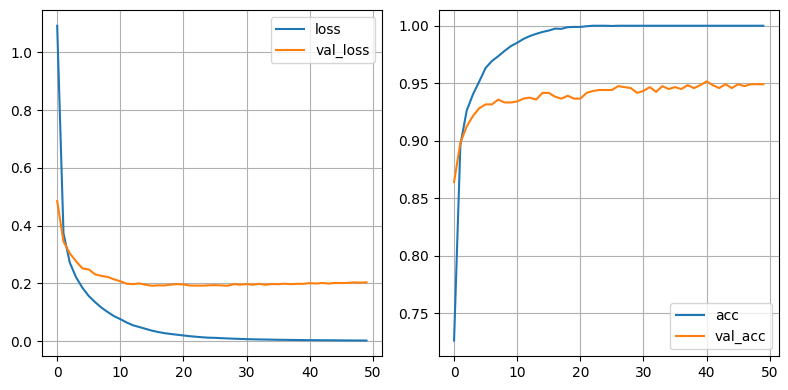

In [8]:
# Model#1.5B
X_train, y_train, X_test, y_test = load_and_prep_mnist()
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
history = compile_and_fit_model(model, X_train, y_train)
print(history_final_values(history))
plot_history(history)

{'loss': 0.0305, 'acc': 0.9967, 'val_loss': 0.2724, 'val_acc': 0.9325}


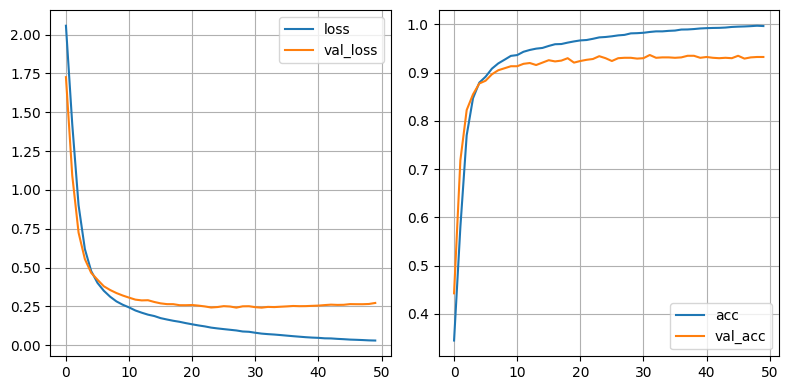

In [9]:
# Model#1.5C
X_train, y_train, X_test, y_test = load_and_prep_mnist()
model = keras.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(10, activation="softmax")
])
history = compile_and_fit_model(model, X_train, y_train)
print(history_final_values(history))
plot_history(history)

{'loss': 0.0019, 'acc': 1.0, 'val_loss': 0.2526, 'val_acc': 0.9367}


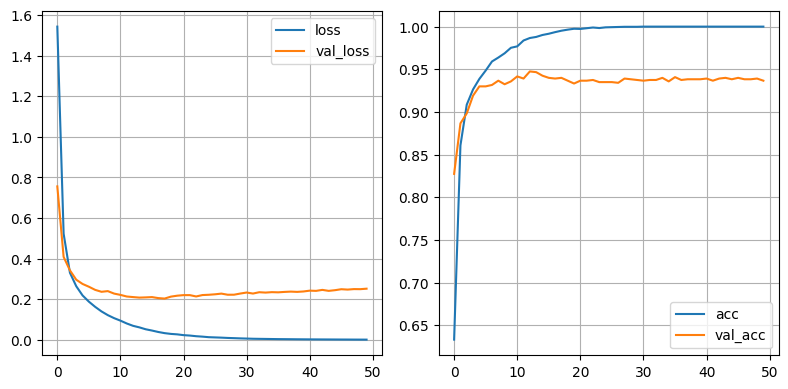

In [10]:
# Model#1.5D
X_train, y_train, X_test, y_test = load_and_prep_mnist()
model = keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax")
])
history = compile_and_fit_model(model, X_train, y_train)
print(history_final_values(history))
plot_history(history)

{'loss': 0.0002, 'acc': 1.0, 'val_loss': 0.2423, 'val_acc': 0.9508}


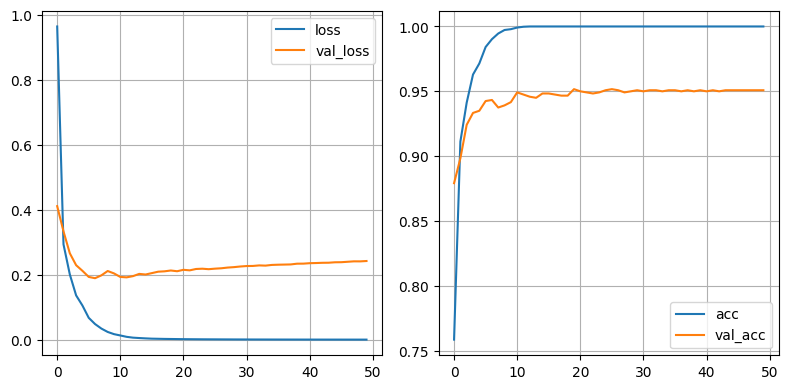

In [11]:
# Model#1.5E = Model#2
X_train, y_train, X_test, y_test = load_and_prep_mnist()
model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])
history = compile_and_fit_model(model, X_train, y_train)
print(history_final_values(history))
plot_history(history)

# Applying regularization (L2)

In this section, L2 regularization is applied to Model#2 for mitigating (i.e. reducing) overfitting. Several models with different strengths of regularization are examined.

# Practice - Question 1 of 3

## Q1a

Modify the code of Model#2 (2 hidden layers, 512 neurons in each hidden layer) to each of the following models with different strengths of regularization:

- Model#2.5A: L2 strength = 0.1
- Model#2.5B: L2 strength = 0.01
- Model#2.5C: L2 strength = 0.001
- Model#2.5D: L2 strength = 0.000_1
- Model#2.5E: L2 strength = 0.000_01
- Model#2.5F: L2 strength = 0.000_001

In Python, underscores (i.e. the `_` character) can be inserted between consecutive digits in a number. E.g. `0.00001` can be written as `0.000_01` for ease to the eye. The following code is an example of applying L2 regularization of strength 0.000_01 in a layer:

```python
layers.Dense(512, activation="relu",
             activity_regularizer=regularizers.l2(0.000_01)),
```

{'loss': 0.1356, 'acc': 0.9962, 'val_loss': 0.5504, 'val_acc': 0.885}


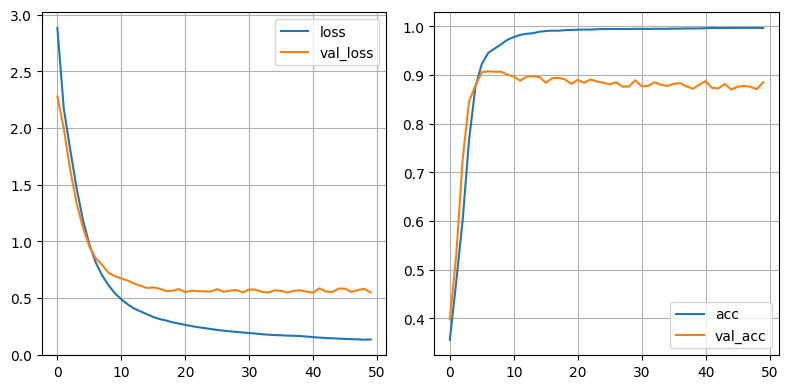

In [14]:
# Model#2.5A
X_train, y_train, X_test, y_test = load_and_prep_mnist()
model = keras.Sequential([
    layers.Dense(512, activation="relu", activity_regularizer=regularizers.l2(0.1)),
    layers.Dense(512, activation="relu", activity_regularizer=regularizers.l2(0.1)),
    layers.Dense(10, activation="softmax")
])
history = compile_and_fit_model(model, X_train, y_train)
print(history_final_values(history))
plot_history(history)

{'loss': 0.0333, 'acc': 1.0, 'val_loss': 0.2812, 'val_acc': 0.9317}


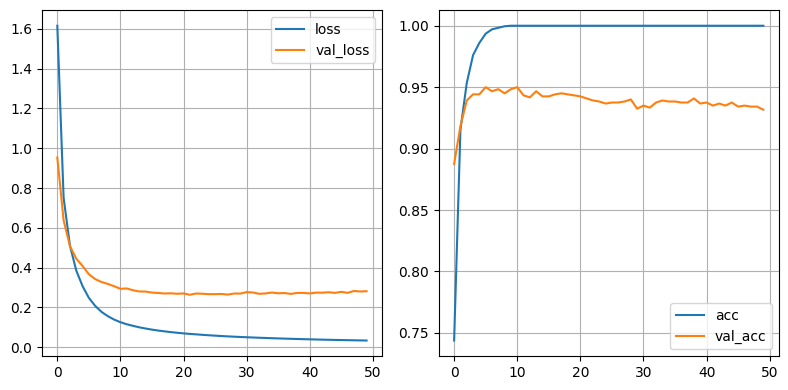

In [15]:
# Model#2.5B

X_train, y_train, X_test, y_test = load_and_prep_mnist()
model = keras.Sequential([
    layers.Dense(512, activation="relu",
             activity_regularizer=regularizers.l2(0.01)),
    layers.Dense(512, activation="relu",
             activity_regularizer=regularizers.l2(0.01)),
    layers.Dense(10, activation="softmax")
])
history = compile_and_fit_model(model, X_train, y_train)
print(history_final_values(history))
plot_history(history)



{'loss': 0.0096, 'acc': 1.0, 'val_loss': 0.2102, 'val_acc': 0.9417}


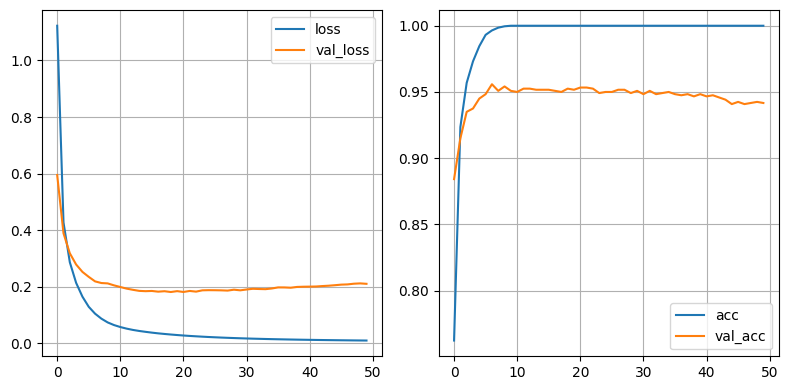

In [16]:
# Model#2.5C
X_train, y_train, X_test, y_test = load_and_prep_mnist()
model = keras.Sequential([
    layers.Dense(512, activation="relu",
             activity_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation="relu",
             activity_regularizer=regularizers.l2(0.001)),
    layers.Dense(10, activation="softmax")
])
history = compile_and_fit_model(model, X_train, y_train)
print(history_final_values(history))
plot_history(history)




{'loss': 0.0038, 'acc': 1.0, 'val_loss': 0.1826, 'val_acc': 0.9525}


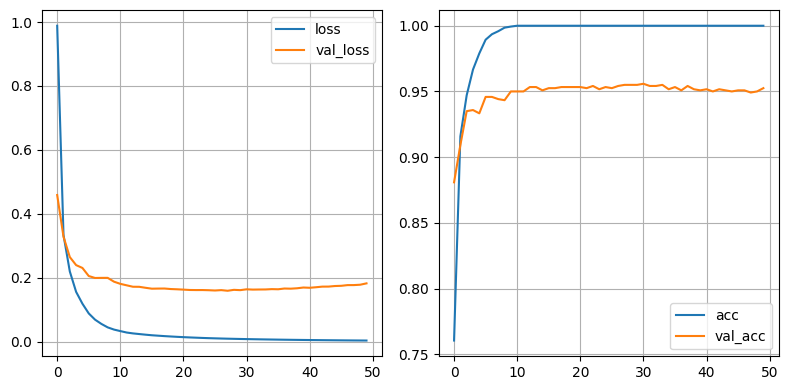

In [17]:
# Model#2.5D
X_train, y_train, X_test, y_test = load_and_prep_mnist()
model = keras.Sequential([
    layers.Dense(512, activation="relu",
             activity_regularizer=regularizers.l2(0.000_1)),
    layers.Dense(512, activation="relu",
             activity_regularizer=regularizers.l2(0.000_1)),
    layers.Dense(10, activation="softmax")
])
history = compile_and_fit_model(model, X_train, y_train)
print(history_final_values(history))
plot_history(history)




{'loss': 0.0026, 'acc': 1.0, 'val_loss': 0.1765, 'val_acc': 0.9508}


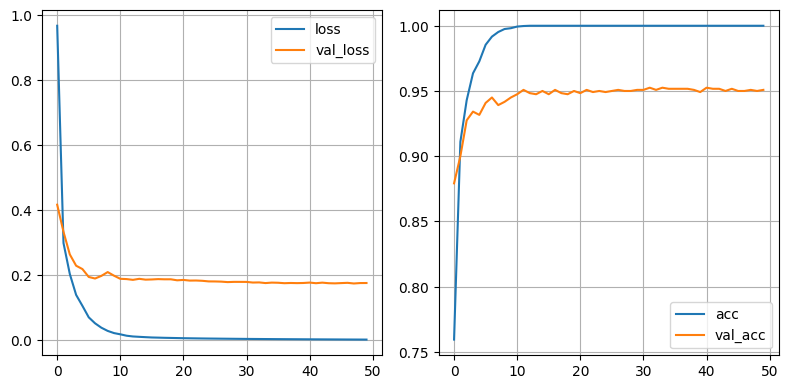

In [18]:
# Model#2.5E = Model#3

X_train, y_train, X_test, y_test = load_and_prep_mnist()
model = keras.Sequential([
    layers.Dense(512, activation="relu",
             activity_regularizer=regularizers.l2(0.000_01)),
    layers.Dense(512, activation="relu",
             activity_regularizer=regularizers.l2(0.000_01)),
    layers.Dense(10, activation="softmax")
])
history = compile_and_fit_model(model, X_train, y_train)
print(history_final_values(history))
plot_history(history)



{'loss': 0.001, 'acc': 1.0, 'val_loss': 0.2128, 'val_acc': 0.9508}


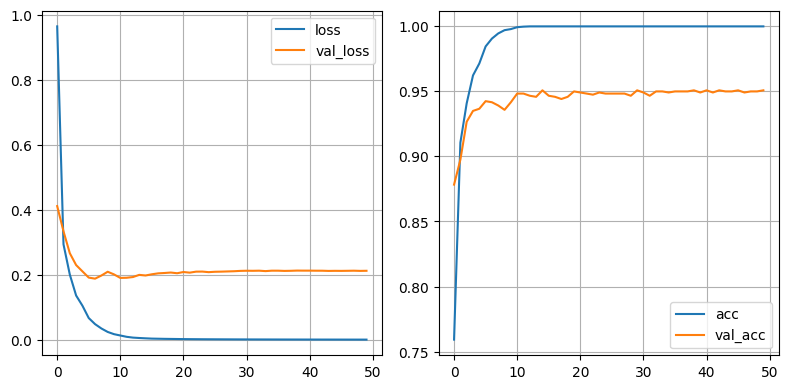

In [19]:
# Model#2.5F
X_train, y_train, X_test, y_test = load_and_prep_mnist()
model = keras.Sequential([
    layers.Dense(512, activation="relu",
             activity_regularizer=regularizers.l2(0.000_001)),
    layers.Dense(512, activation="relu",
             activity_regularizer=regularizers.l2(0.000_001)),
    layers.Dense(10, activation="softmax")
])
history = compile_and_fit_model(model, X_train, y_train)
print(history_final_values(history))
plot_history(history)





## Q1b

A table template is provided below.

Model | L2 regularization strength | Val Loss | Val Accuracy | Overfitting
:-:|:-:|:-:|:-:|:-:
#2.5A | 0.1 | ? | ? | ?
#2.5B | 0.01 | ? | ? | ?
#2.5C | 0.001 | ? | ? | ?
#2.5D | 0.000_1 | ? | ? | ?
#2.5E / #3 | 0.000_01 | ? | ? | ?
#2.5F | 0.000_001 | ? | ? | ?

Make a copy of the table. Referring to the execution outputs, fill in the validation results and overfitting status in the table.

Solution:


Model | L2 regularization strength | Val Loss | Val Accuracy | Overfitting
:-:|:-:|:-:|:-:|:-:
#2.5A | 0.1 | 0.5504 | 0.885 | NO
#2.5B | 0.01 | 0.2812 | 0.9317 | Slight
#2.5C | 0.001 | 0.2102 | 0.9417 | Slight
#2.5D | 0.000_1 | 0.1826 | 0.9525 | Slight
#2.5E / #3 | 0.000_01 | 0.1765 | 0.9508 | NO
#2.5F | 0.000_001 | 0.2423 | 0.9508 | Moderate


## &#x2766;

# Increasing model complexity again

In the preceding section, we should find that Model#2.5E (with L2 strength 0.000_01) is a proper model that mitigate the overfitting problem of Model#2. In this section, we go on with Model#2.5E (let's call it Model#3 from now on) and increase the model complexity to see if we can obtain better performance.

# Practice - Question 2 of 3

## Q2a

Modify the code of Model#3 (with L2 strength 0.000_01) to each of the following models with different number of hidden layers and/or number of neurons in each hidden layer:

- Model#3.5A: 2 hidden layers, 1024 neurons in each hidden layer
- Model#3.5B: 3 hidden layers, 1024 neurons in each hidden layer
- Model#3.5C: 2 hidden layers, 2048 neurons in each hidden layer

{'loss': 0.0015, 'acc': 1.0, 'val_loss': 0.1576, 'val_acc': 0.9575}


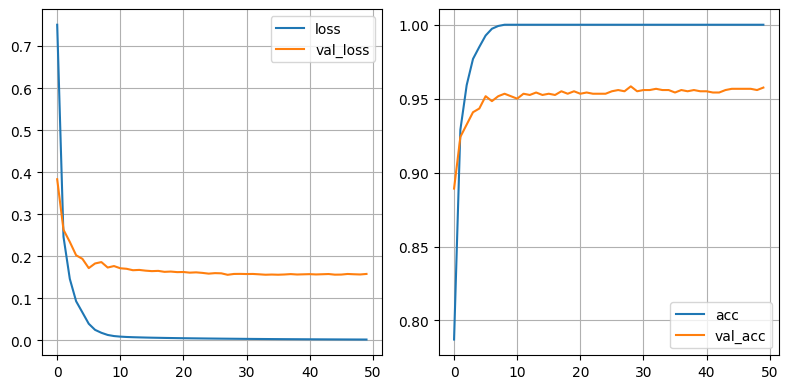

In [20]:
# Model#3.5A
X_train, y_train, X_test, y_test = load_and_prep_mnist()
model = keras.Sequential([
    layers.Dense(1024, activation="relu",
             activity_regularizer=regularizers.l2(0.000_01)),
    layers.Dense(1024, activation="relu",
             activity_regularizer=regularizers.l2(0.000_01)),
    layers.Dense(10, activation="softmax")
])
history = compile_and_fit_model(model, X_train, y_train)
print(history_final_values(history))
plot_history(history)




{'loss': 0.0009, 'acc': 1.0, 'val_loss': 0.1636, 'val_acc': 0.9533}


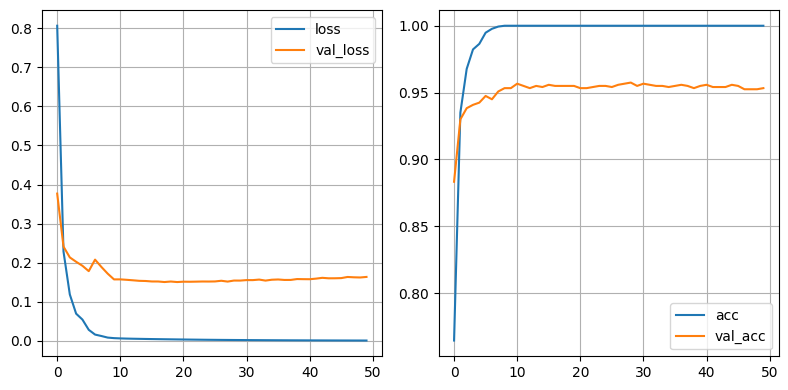

In [21]:
# Model#3.5B

X_train, y_train, X_test, y_test = load_and_prep_mnist()
model = keras.Sequential([
    layers.Dense(1024, activation="relu",
             activity_regularizer=regularizers.l2(0.000_01)),
    layers.Dense(1024, activation="relu",
             activity_regularizer=regularizers.l2(0.000_01)),
    layers.Dense(1024, activation="relu",
             activity_regularizer=regularizers.l2(0.000_01)),
    layers.Dense(10, activation="softmax")
])
history = compile_and_fit_model(model, X_train, y_train)
print(history_final_values(history))
plot_history(history)





{'loss': 0.001, 'acc': 1.0, 'val_loss': 0.1392, 'val_acc': 0.9608}


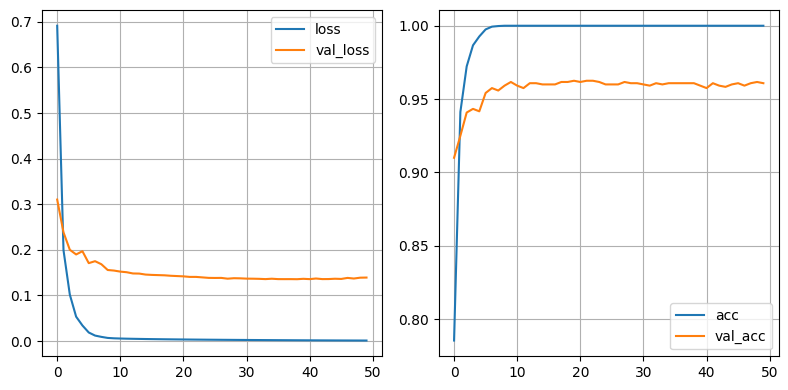

In [22]:
# Model#3.5C = Model#4
X_train, y_train, X_test, y_test = load_and_prep_mnist()
model = keras.Sequential([
    layers.Dense(2048, activation="relu",
             activity_regularizer=regularizers.l2(0.000_01)),
    layers.Dense(2048, activation="relu",
             activity_regularizer=regularizers.l2(0.000_01)),
    layers.Dense(10, activation="softmax")
])
history = compile_and_fit_model(model, X_train, y_train)
print(history_final_values(history))
plot_history(history)





## Q2b

A table template is provided below.

Model | Hidden layers | Neurons in a hidden layer | Val Loss | Val Accuracy | Overfitting
:-:|:-:|:-:|:-:|:-:|:-:
#3.5A | 2 | 1024 | ? | ? | ?
#3.5B | 3 | 1024 | ? | ? | ?
#3.5C / #4| 2 | 2048 | ? | ? | ?

Make a copy the table. Referring to the execution outputs, fill in the validation results and overfitting status in the table.

Solution:

Model | Hidden layers | Neurons in a hidden layer | Val Loss | Val Accuracy | Overfitting
:-:|:-:|:-:|:-:|:-:|:-:
#3.5A | 2 | 1024 | 0.1576 | 0.9575 | No
#3.5B | 3 | 1024 | 0.1636 | 0.9533 | Slight
#3.5C / #4| 2 | 2048 | 0.1392 | 0.9608 | Slight


## &#x2766;

The code below can be used to evaluate the model using the test set (before retraining).

In [23]:
print("Evaluation", model.evaluate(X_test, y_test, verbose=0))

Evaluation [0.16928909718990326, 0.9539999961853027]


# Retraining the best model

In the preceding section, we should find the Model#3.5C has the lowest validation loss and highest validation accuracy, even though there is slight overfitting. Let's assume its performance is acceptable (or we're running out of time to find a better model!). We next retain this Model#3.5C (let's call it Model#4 from now on) using both the training set and the validation set combined.

# Practice - Question 3 of 3

## Q3a

Write code to retrain Model#4 (i.e. Model#3.5C) using both the training set and the validation set combined. Specifically, modify the code of Model#4 to replace the line that calls the `compile_and_fit_model()` function and all subsequent lines of code with this code:

```python
model.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=["acc"])
history = model.fit(X_train, y_train, epochs=50, batch_size=256,
                    verbose=0) # no validation_split
print(history_final_values(history))
```

In [24]:
#Model # 4
X_train, y_train, X_test, y_test = load_and_prep_mnist()
model = keras.Sequential([
    layers.Dense(2048, activation="relu",
             activity_regularizer=regularizers.l2(0.000_01)),
    layers.Dense(2048, activation="relu",
             activity_regularizer=regularizers.l2(0.000_01)),
    layers.Dense(10, activation="softmax")
])
model.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=["acc"])
history = model.fit(X_train, y_train, epochs=50, batch_size=256,
                    verbose=0) # no validation_split
print(history_final_values(history))





{'loss': 0.0006, 'acc': 1.0}


## Q3b

Write code to evaluate the retrained model above using the test set, i.e. `X_test` and `y_test`. This performs a final assessment of the selected best model.

In [25]:
print("Evaluation", model.evaluate(X_test, y_test, verbose=0))

Evaluation [0.1623714566230774, 0.9570000171661377]


## &#x2766;

# Extras

The validation results of Model#3.5C, i.e. Model#4, indicate slight overfitting. In the following, we try to apply L1 regularization in addition to L2 regularization to reduce overfitting.

## Applying regularization (L1+L2)

### E1a

In addition to L2 regularization of strength 0.000_01, examine models with L1 regularization as follows. All models use 2 hidden layers, and 2048 neurons in each hidden layer, as in Model#4.

- Model#4.5A: L1 strength = 0.000_1, L2 strength = 0.000_01.
- Model#4.5B: L1 strength = 0.000_01, L2 strength = 0.000_01.
- Model#4.5C: L1 strength = 0.000_001, L2 strength = 0.000_01.

Tabulate the results and select the best model among them.

### E1b

Retrain the best model using the training set and the validation set combined, and evaluate the retrained model using the test set.

## Solutions to extra exercises

### E1a

{'loss': 0.0025, 'acc': 1.0, 'val_loss': 0.1806, 'val_acc': 0.9517}


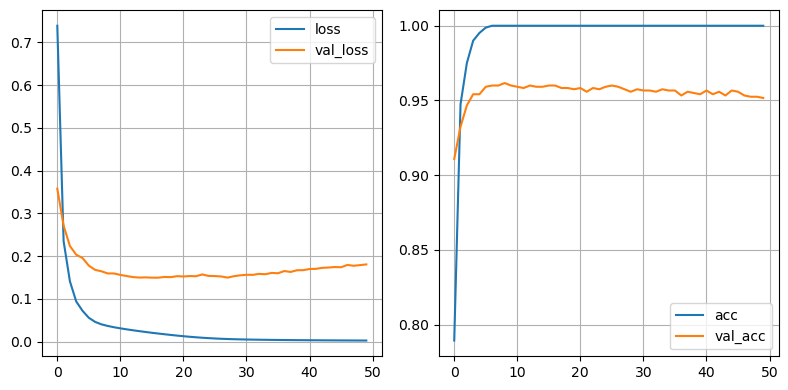

In [ ]:
# Solution

# Model#4.5A
X_train, y_train, X_test, y_test = load_and_prep_mnist()
model = keras.Sequential([
    layers.Dense(2048, activation="relu",
                 activity_regularizer=regularizers.l1_l2(0.000_1, 0.000_01)),
    layers.Dense(2048, activation="relu",
                 activity_regularizer=regularizers.l1_l2(0.000_1, 0.000_01)),
    layers.Dense(10, activation="softmax")
])
history = compile_and_fit_model(model, X_train, y_train)
print(history_final_values(history))
plot_history(history)

{'loss': 0.0017, 'acc': 1.0, 'val_loss': 0.1537, 'val_acc': 0.9558}


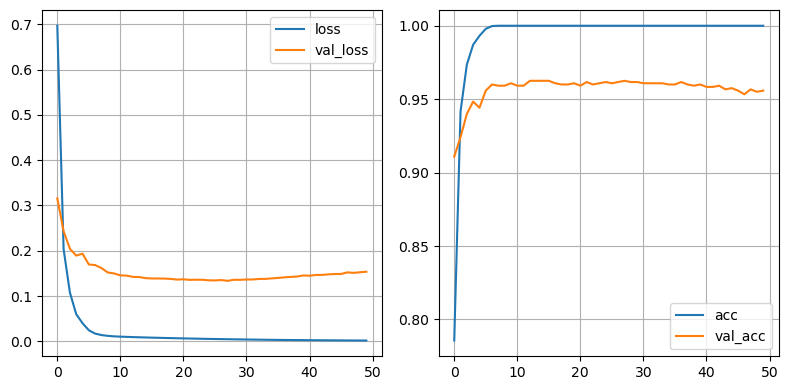

In [ ]:
# Solution

# Model#4.5B
X_train, y_train, X_test, y_test = load_and_prep_mnist()
model = keras.Sequential([
    layers.Dense(2048, activation="relu",
                 activity_regularizer=regularizers.l1_l2(0.000_01, 0.000_01)),
    layers.Dense(2048, activation="relu",
                 activity_regularizer=regularizers.l1_l2(0.000_01, 0.000_01)),
    layers.Dense(10, activation="softmax")
])
history = compile_and_fit_model(model, X_train, y_train)
print(history_final_values(history))
plot_history(history)

{'loss': 0.0011, 'acc': 1.0, 'val_loss': 0.1401, 'val_acc': 0.9625}


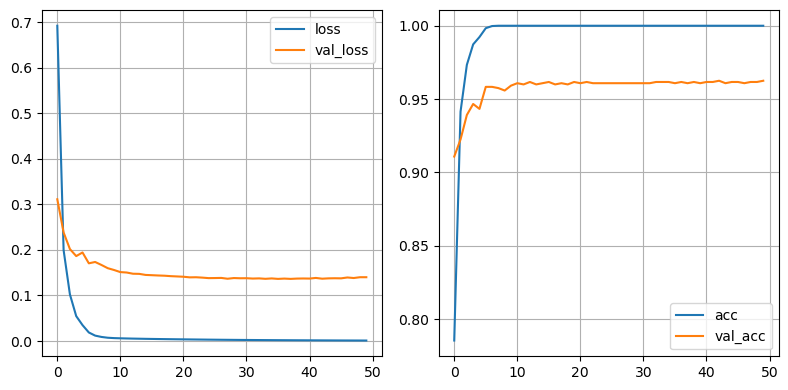

In [ ]:
# Solution

# Model#4.5C = Model#5
X_train, y_train, X_test, y_test = load_and_prep_mnist()
model = keras.Sequential([
    layers.Dense(2048, activation="relu",
                 activity_regularizer=regularizers.l1_l2(0.000_001, 0.000_01)),
    layers.Dense(2048, activation="relu",
                 activity_regularizer=regularizers.l1_l2(0.000_001, 0.000_01)),
    layers.Dense(10, activation="softmax")
])
history = compile_and_fit_model(model, X_train, y_train)
print(history_final_values(history))
plot_history(history)

In [ ]:
print("Evaluation", model.evaluate(X_test, y_test, verbose=0))

Evaluation [0.17030948400497437, 0.953000009059906]


The results are tabulated below. Among the three, Model#4.5C has the lowest validation loss, highest validation accuracy, and no overfitting; it is the best model and is also called Model#5 from now on.

Model | L1 strength | L2 strength | Val Loss | Val Accuracy | Overfitting
:-:|:-:|:-:|:-:|:-:|:-:
#4.5A | 0.000_1 | 0.000_01 | 0.1806 | 0.9517 | Moderate
#4.5B | 0.000_01 | 0.000_01 | 0.1537 | 0.9558 | Moderate
#4.5C / #5 | 0.000_001 | 0.000_01 | 0.1401 | 0.9625 | No

### E1b

Model #4.5C, i.e. Model #5, is retrained and evaluated as follows.

In [ ]:
# Solution

# Retrain using training set and validation set combined
X_train, y_train, X_test, y_test = load_and_prep_mnist()
model = keras.Sequential([
    layers.Dense(2048, activation="relu",
                 activity_regularizer=regularizers.l1_l2(0.000_001, 0.000_01)),
    layers.Dense(2048, activation="relu",
                 activity_regularizer=regularizers.l1_l2(0.000_001, 0.000_01)),
    layers.Dense(10, activation="softmax")
])

model.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=["acc"])
history = model.fit(X_train, y_train, epochs=50, batch_size=256,
                    verbose=0) # no validation_split
print(history_final_values(history))

{'loss': 0.0007, 'acc': 1.0}


In [ ]:
# Solution
print("Evaluation of retrained model",
      model.evaluate(X_test, y_test, verbose=0))

Evaluation of retrained model [0.15892967581748962, 0.9580000042915344]


## &#x2766;